In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance

In [3]:
nlp = spacy.load('es', vectors=False, entity=False)

In [4]:
filename = "lavoztextodump.txt"
text_file = open(filename, "r")
dataset = text_file.read()
text_file.close()

In [5]:
doc = nlp(dataset)

In [6]:
sents = [sent for sent in doc.sents if len(sent) > 10]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts = Counter(words_lemma)

Counter({'de': 212, 'la': 140, 'que': 129, 'el': 104, 'y': 98, 'en': 95, 'a': 77, 'los': 68, 'se': 53, 'las': 43, 'es': 40, 'un': 32, 'no': 32, 'una': 31, 'por': 28, 'del': 28, 'para': 26, 'con': 25, 'más': 20, 'años': 19, 'lo': 19, 'me': 16, 'su': 13, 'cuando': 13, 'como': 13, 'uno': 12, 'o': 12, 'son': 11, 'hay': 11, 'pero': 11, 'nos': 11, 'maría': 10, 'entre': 10, 'estancias': 10, 'al': 10, 'educación': 9, 'este': 8, 'jesús': 8, 'año': 8, 'todo': 8, 'otro': 8, 'han': 8, 'también': 7, 'día': 7, 'pedro': 7, 'dos': 7, 'tiempo': 7, 'ya': 7, 'siempre': 6, 'cuatro': 6, 'sitios': 6, 'está': 6, 'unesco': 6, 'vida': 6, 'tan': 6, 'córdoba': 6, 'veces': 6, 'cinco': 6, 'sólo': 6, 'hasta': 6, 'porque': 5, 'algunos': 5, 'tiene': 5, 'patrimonio': 5, 'gusta': 5, 'menos': 5, 'caroya': 5, 'le': 5, 'mejor': 5, 'asegura': 5, 'desde': 5, 'después': 5, 'gracia': 5, 'qué': 5, 'alta': 5, 'ser': 5, 'había': 5, 'dice': 5, 'casa': 5, 'mary': 5, 'provincia': 5, 'hace': 5, 'además': 4, 'jesuítico': 4, 'estar': 

In [7]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags

In [8]:
lemma_file = open("lemmatization-es.txt", "r")
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]

In [9]:
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word

In [21]:
# Crear diccionario
dicc = {}
list_dicc = {}
word_id = 0
threshold_w = 100
threshold_c = 50

for word in words:
    w = lemmatize(word.lemma_)
    if not word.is_alpha or str.isdigit(w) or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    tags = parse_tags(word)
    for tag in tags:
        if not tag in features:
            features[tag] = 0
        features[tag] += 1

    if not word.i == 0:
        context_izq = doc[word.i - 1]
        c_izq = lemmatize(context_izq.lemma_)
        if context_izq.is_alpha and counts[c_izq] > threshold_c:
            if str.isdigit(c_izq):
                c_izq = "NUM__"
            if not c_izq in contexts:
                features[c_izq] = 0
            features[c_izq] += 1

    if not word.i < len(doc):
        context_der = doc[word.i + 1]
        c_der = lemmatize(context_der.lemma_)
        if context_der.is_alpha and counts[c_der] > threshold_c:
            if str.isdigit(c_der):
                c_der = "NUM__"
            if not c_der in features:
                features[c_der] = 0
            features[c_der] += 1

    tripla = "TRIPLA__" + w + "__" + word.lemma_ + "__" + word.dep_ + "__" + lemmatize(word.head.lemma_)
    if not tripla in features:
        features[tripla] = 0
    features[tripla] += 1

    word_id += 1

    dicc[w] = features

In [16]:
filename = "lavoz_dicc.pickle"
fileObj = open(filename, 'wb')
pickle.dump(dicc, fileObj)
fileObj.close()

In [18]:
filename = "lavoz_dicc.pickle"
with open(filename, 'rb') as f:
    dicc = pickle.load(f)

In [20]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [ ]:
filename = "lavoz_cleandicc.pickle"
fileObj = open(filename, 'wb')
pickle.dump(features, fileObj)
fileObj.close()

filename = "lavoz_keys.pickle"
fileObj = open(filename, 'wb')
pickle.dump(key_words, fileObj)
fileObj.close()

In [31]:
filename = "lavoz_cleandicc.pickle"
with open(filename, 'rb') as f:
    features = pickle.load(f)
    
filename = "lavoz_keys.pickle"
with open(filename, 'rb') as f:
    key_words = pickle.load(f)

In [12]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [13]:
matrix_normed = matrix / matrix.max(axis=0)

In [25]:
filename = "lavoz_matrix.pickle"
fileObj = open(filename, 'wb')
pickle.dump(matrix_normed, fileObj)
fileObj.close()

In [26]:
filename = "lavoz_matrix.pickle"
with open(filename, 'rb') as f:
    matrix_normed = pickle.load(f)

In [14]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(matrix_normed)

In [28]:
filename = "lavoz_matrix2d.pickle"
fileObj = open(filename, 'wb')
pickle.dump(matrix_dicc2d, fileObj)
fileObj.close()

In [25]:
filename = "lavoz_matrix2d.pickle"
with open(filename, 'rb') as f:
    matrix_dicc2d = pickle.load(f)

In [33]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

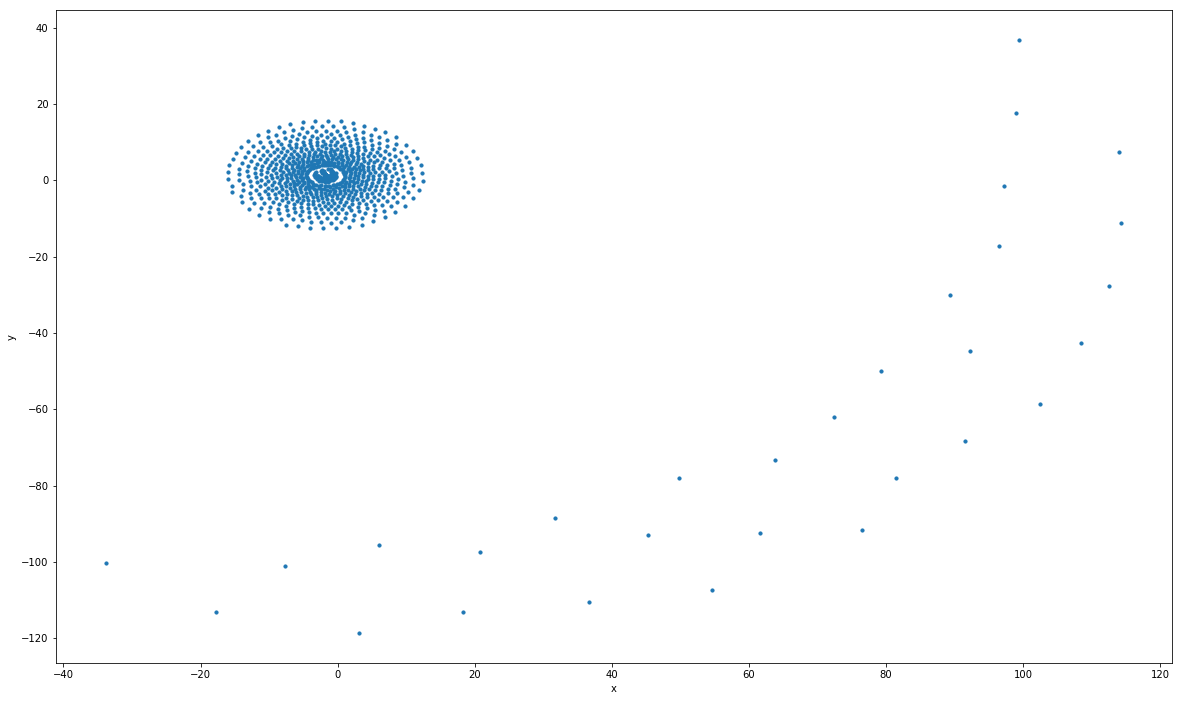

In [34]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [58]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [18]:
#plot_region(x_bounds=(-40, 30), y_bounds=(-40, -20))

In [63]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(matrix_normed, True)
    return clusters

In [37]:
c50 =  clustering(50)
c100 = clustering(100)
c150 = clustering(150)

In [35]:
filename = "lavoz_cluster50.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c50, fileObj)
fileObj.close()

In [38]:
filename = "lavoz_cluster100.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c100, fileObj)
fileObj.close()

In [40]:
filename = "lavoz_cluster150.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c150, fileObj)
fileObj.close()

In [24]:
filename = "lavoz_cluster50.pickle"
with open(filename, 'rb') as f:
    clusters = pickle.load(f)

In [64]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

In [19]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [66]:
def plot_region_cluster(x_bounds, y_bounds):
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [20]:
plot_region_cluster(x_bounds=(-40, 30), y_bounds=(-40, -20))